# **AEGIS LENS EXPLORATORY DATA ANALYSIS**

## i. Import Libraries

Pada tahap ini kita akan melakukan import libraries yang di perlukan untuk kebutuhan Exploratory Data Analysis. Library ini akan terus update tergantung apa yang akan kita eksplor dibawah.

In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

## ii. Split Data Train and Val

Pada tahap ini kita akan melakukan split dataset menjadi 2 bagian, yaitu train dan validation. Kita membagi dataset menjadi 80 % untuk data train dan 20 % untuk data validation.

In [2]:
#Split Train dan Val
base_dir = "Dataset"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

output_dirs = {
    "train": 0.8,
    "val": 0.2,
}

for split in output_dirs:
    os.makedirs(os.path.join(base_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, "labels"), exist_ok=True)

image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

total = len(image_files)
start = 0
for split, ratio in output_dirs.items():
    count = int(total * ratio)
    selected_files = image_files[start:start + count]
    for file in selected_files:
        src_img = os.path.join(images_dir, file)
        dst_img = os.path.join(base_dir, split, "images", file)
        shutil.copy(src_img, dst_img)

        label_file = file.rsplit('.', 1)[0] + ".txt"
        src_label = os.path.join(labels_dir, label_file)
        dst_label = os.path.join(base_dir, split, "labels", label_file)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)

    start += count

## iii. Loading Data for EDA

Pada tahap ini kita akan loading dataset train yang sudah di split dari dataset utama. Dataset train inilah yang akan kita analisis, dimana diharapkan hasil analisis ini dapat membantu kita dalam pembuatan model.

In [12]:
#Dataset Train path
images_dir = 'Dataset/train/images'
labels_dir = 'Dataset/train/labels'

In [13]:
#Melihat Semua Label/Class
classes_path = 'Dataset/classes.txt'

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Class Names:")
for idx, class_name in enumerate(classes):
    print(f"{idx}: {class_name}")

Class Names:
0: Bus
1: Car
2: LicensePlate
3: Motorcycle
4: Truck


Insight : 

Terdapat 5 Class/Label, yaitu :

0 untuk Bus  
1 untuk Car  
2 untuk LicensePlate  
3 untuk Motorcycle  
4 untuk Truck  

Kelas-kelas tersebut adalah jenis-jenis kendaraaan yang kita klasifikasikan serta 1 plat nomor kendaraan yang akan di deteksi nomornya.

In [14]:
#Loading data train
records = []

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    image = plt.imread(image_path)
    h, w = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            records.append({
                'image': image_file,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height != 0 else 0
            })

df = pd.DataFrame(records)

## iv. EDA

Pada bagian ini kita akan melakukan beberapa analisis pada dataset, berikut adalah beberapa pertanyaan yang harus di analisis pada dataset : 

1. Bagaimana distribusi objek di tiap kelas?
2. Bagaimana sebaran jumlah objek yang terdapat pada gambar?
3. Bagaimana pola distribusi ukuran bounding box setiap kelas?
4. Seperti apa distribusi rasio bouding box (lebar dibandingkan tinggi)?
5. Berikan contoh visualiasi gambar yang telah di labeling?
6. Bagaimana gambaran heatmap posisi centroid box?

### 1. Distribusi objek di setiap kelas

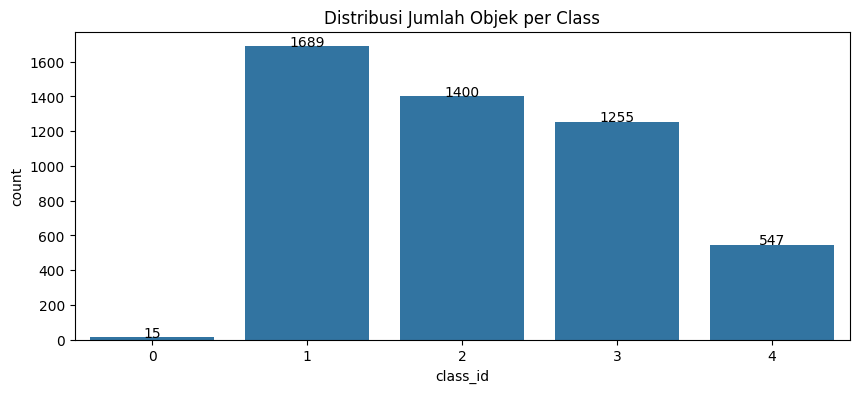

In [6]:
# Plot Distribusi jumlah objek per class
plt.figure(figsize=(10,4))
ax = sns.countplot(x='class_id', data=df)
plt.title('Distribusi Jumlah Objek per Class')

# Menambahkan angka di atas setiap bar
for p in ax.patches:
    height = p.get_height()  # tinggi bar = jumlah objek
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,  # posisi teks ditengah atas bar
            int(height), 
            ha="center")  # ha = horizontal alignment center

plt.show()

Insight :  

- Diagram bar diatas menggambarkan distribusi kelas di dataset train 
- Di kelas 0 (Bus) terlihat datanya sangat sedikit dibandingkan 4 kelas lainnya. Ini menggambarkan bahwa terlihat adanya imbalance data.
- Kelas 1 (Car) mempunyai data yang paling banyak, lalu kelas 2 (LicensePlate) dan 3 (Motorcycle) berada di urutan kedua dan ketiga, dimana perbedaan jumlah kelas 2 dan 3 ada disekitar 145 data. 
- Kelas 4 (Truck) juga mempunyai data yang terbilang sedikit walaupun masih jauh lebih banyak dari data kelas 0 (Bus)
- Dari keluruhan bisa disimpulkan bahwa di jalanan tempat pengambilan data masih di dominasi dengan mobil dan motor.
- LicensePlate kalau dibandingkan dengan data semua kelas maka termasuk sedikit kendaraan bisa di label LicensePlatenya
- Dari keseluruhan data, jika ingin mengatasi data unbalance pada kelas 0 (Bus) dan kelas 1 (Truck) bisa dilakukan pengambilan sampling lagi, dimana untuk Bus pengambilan sampling harus di jalan sekitar terminal-terminal bus serta untuk pengambilan sampling Truk bisa di daerah yang di dominasi pabrik-pabrik atau gudang logistik. 

___________________________________________________________________________________________________________________________________________________________________________________________
Berdasarkan insight di atas dimana class 0 (Bus) sangat sedikit, saya akan coba perlihatkan contoh gambar yang ada kelas 0

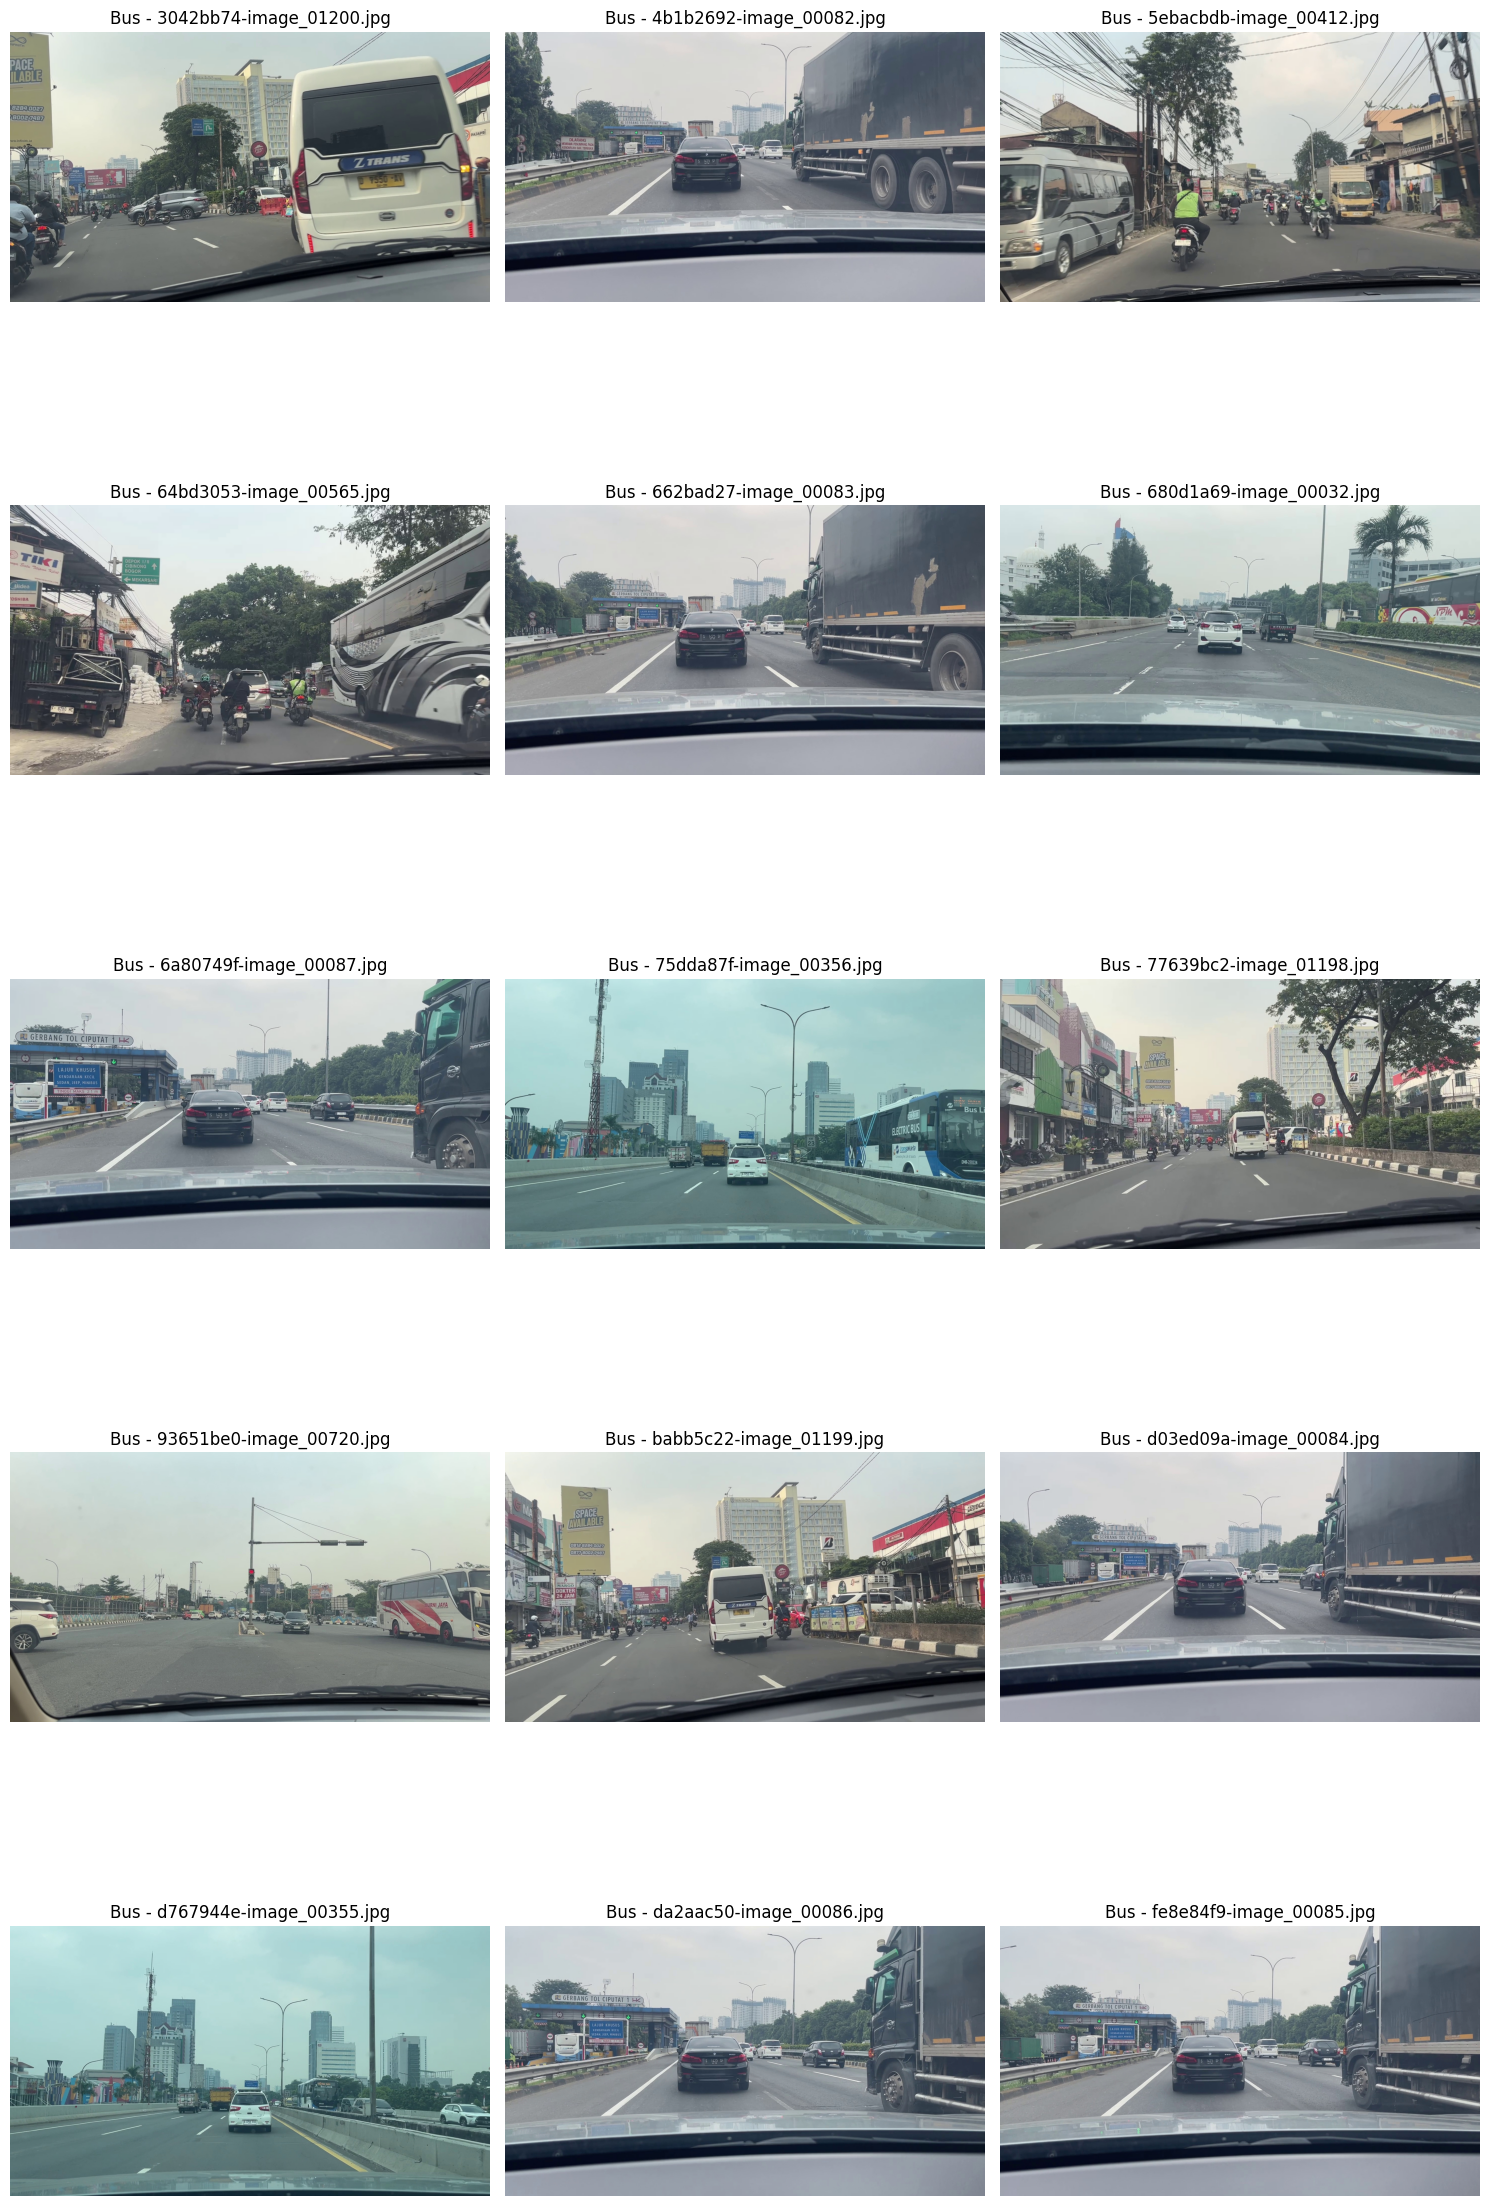

In [ ]:
max_images = 15 
cols = 3   
rows = max_images // cols + int(max_images % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

count = 0
for label_file in os.listdir(labels_dir):
    if not label_file.endswith('.txt'): continue
    label_path = os.path.join(labels_dir, label_file)

    with open(label_path, 'r') as f: lines = f.readlines()
    if not any(line.startswith('0 ') for line in lines): continue

    image_file = label_file.replace('.txt', '.jpg')
    image_path = os.path.join(images_dir, image_file)
    if not os.path.exists(image_path): continue

    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    axes[count].imshow(img)
    axes[count].set_title(f"Bus - {image_file}")
    axes[count].axis('off')

    count += 1
    if count >= max_images: break

for i in range(count, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### 2. Sebaran jumlah objek yang terdapat pada gambar

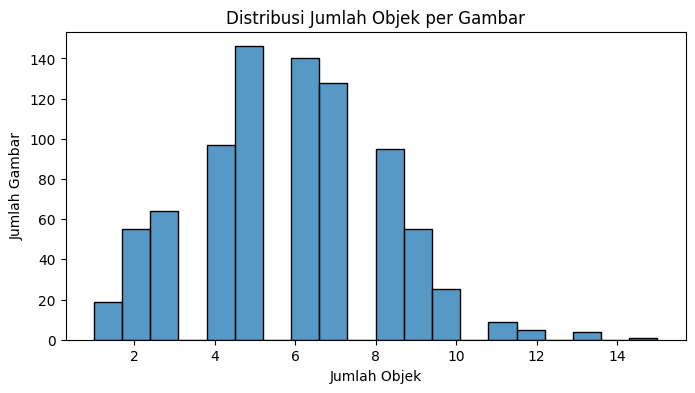

In [7]:
# Distribusi jumlah objek per gambar
obj_per_image = df.groupby('image').size()
plt.figure(figsize=(8,4))
sns.histplot(obj_per_image, bins=20, kde=False)
plt.title('Distribusi Jumlah Objek per Gambar')
plt.xlabel('Jumlah Objek')
plt.ylabel('Jumlah Gambar')
plt.show()

Insight :  

- Diagram diatas menunjukkan distribusi objek yang di label per gambar
- Hasil dari diagaram diatas menunjukkan rata-rata gambar terdapat 4 sampai 8 objek maksimalnya

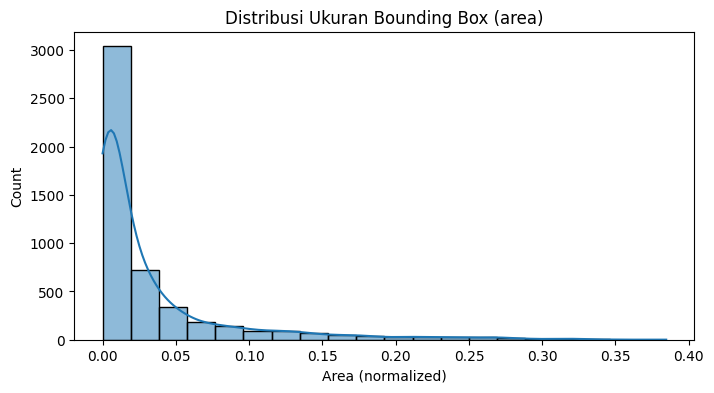

In [8]:
# Distribusi ukuran bbox (area)
plt.figure(figsize=(8,4))
sns.histplot(df['area'], bins=20, kde=True)
plt.title('Distribusi Ukuran Bounding Box (area)')
plt.xlabel('Area (normalized)')
plt.show()

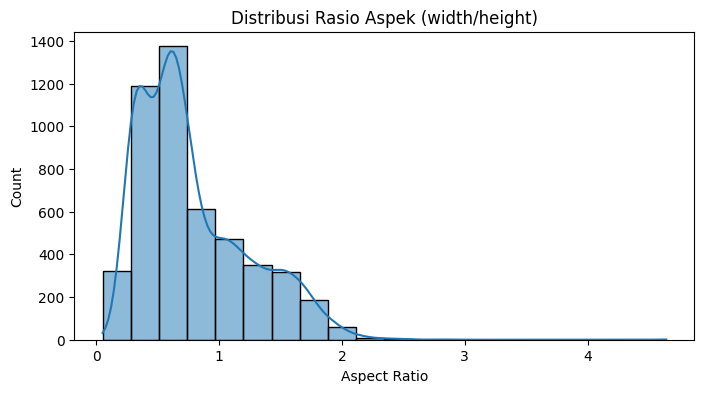

In [9]:
# Distribusi rasio aspek bbox
plt.figure(figsize=(8,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True)
plt.title('Distribusi Rasio Aspek (width/height)')
plt.xlabel('Aspect Ratio')
plt.show()

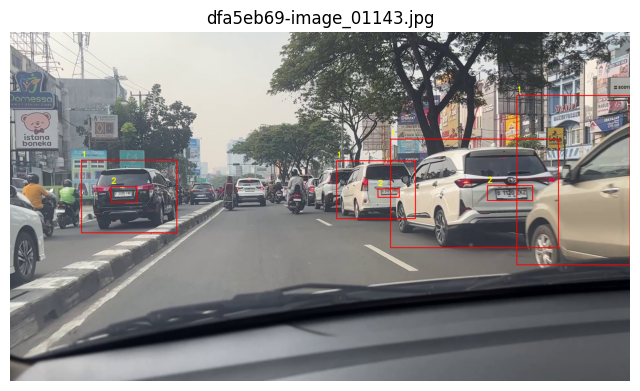

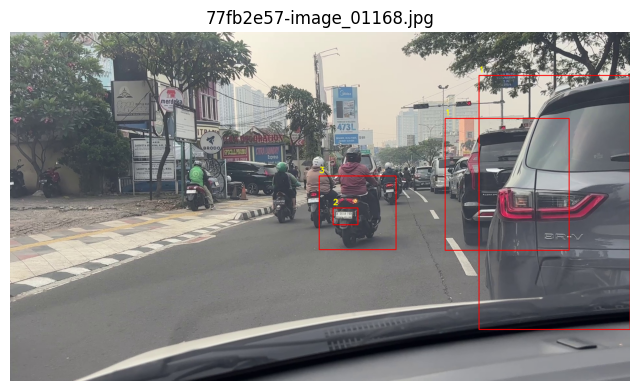

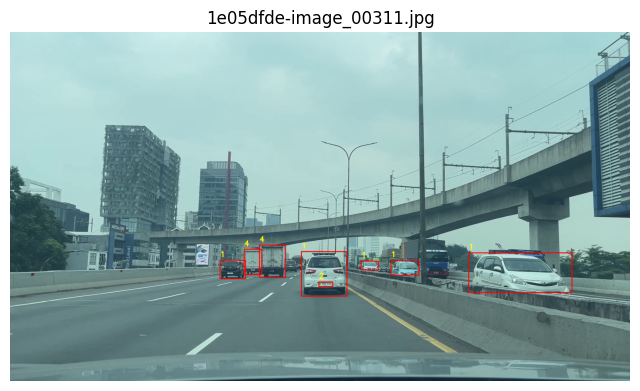

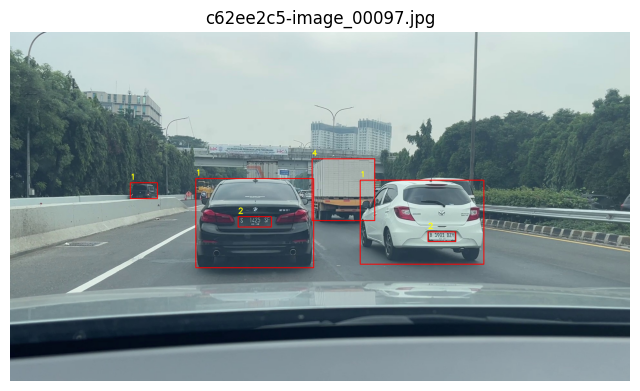

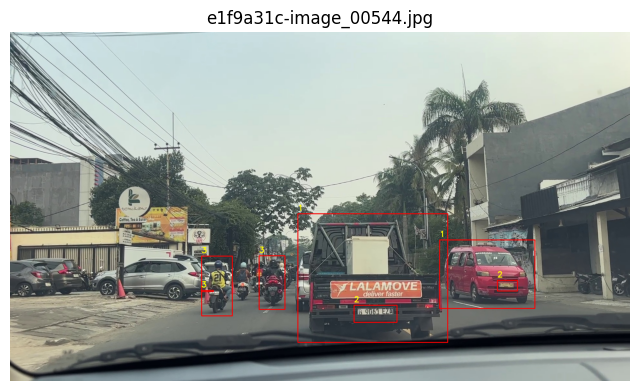

In [10]:
# Visualisasi 5 gambar random + bbox
sample_images = df['image'].unique()
sample_images = np.random.choice(sample_images, size=min(5, len(sample_images)), replace=False)

for image_file in sample_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = df[df['image']==image_file]
    for _, row in boxes.iterrows():
        xmin = int((row['x_center'] - row['width']/2) * w)
        ymin = int((row['y_center'] - row['height']/2) * h)
        xmax = int((row['x_center'] + row['width']/2) * w)
        ymax = int((row['y_center'] + row['height']/2) * h)
        class_id = row['class_id']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

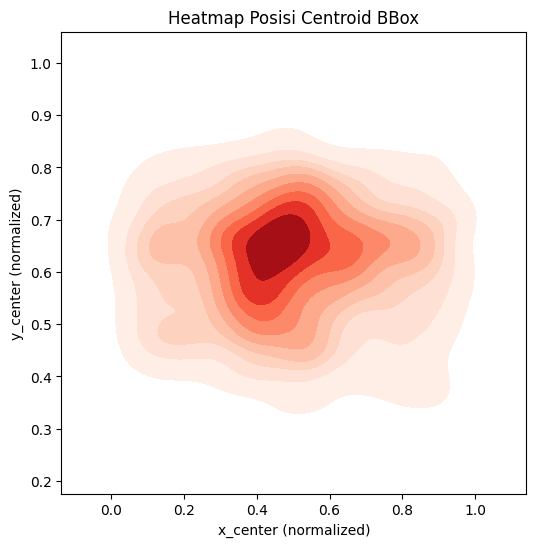

In [11]:
# Heatmap sebaran posisi centroid bbox
plt.figure(figsize=(6,6))
sns.kdeplot(x=df['x_center'], y=df['y_center'], fill=True, cmap='Reds')
plt.title('Heatmap Posisi Centroid BBox')
plt.xlabel('x_center (normalized)')
plt.ylabel('y_center (normalized)')
plt.show()